In [ ]:
using Revise

In [1]:
using Distributed
procs_to_use = 10
if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end
;

In [2]:
@everywhere using QuantumStates, OpticalBlochEquations, DifferentialEquations, UnitsToValue, StructArrays, StaticArrays, 
    Parameters

@everywhere import Distributions: Normal, Geometric, Exponential
@everywhere using ProgressMeter, Plots
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]


In [3]:
# @everywhere begin
#     include("helper_functions.jl")
#     include("define_CaOH_molecular_structure.jl")
#     include("define_sim_params.jl")
#     include("define_blueMOT_1plus1.jl")
#     include("define_blueMOT_1plus2.jl")
# end
# ;

In [174]:
@everywhere include("helper_functions.jl")
include("define_CaOH_molecular_structure.jl")
include("define_sim_params.jl")
include("define_blueMOT_1plus1.jl")
include("define_blueMOT_1plus2.jl")
;

# Figure 3

In [175]:
include("compute_size_temperature.jl")
;

In [176]:
n_trajectories1 = 100
n_trajectories2 = 100
n_trajectories_diffusion = 20000
n_times = 100
diffusion_t_end = 20e-6
diffusion_τ_total = 20e-6
;

In [79]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:08:05
Progress: 100%|█████████████████████████████████████████| Time: 0:17:41
Progress: 100%|█████████████████████████████████████████| Time: 0:07:50
Progress: 100%|█████████████████████████████████████████| Time: 0:17:43
Progress: 100%|█████████████████████████████████████████| Time: 0:08:10


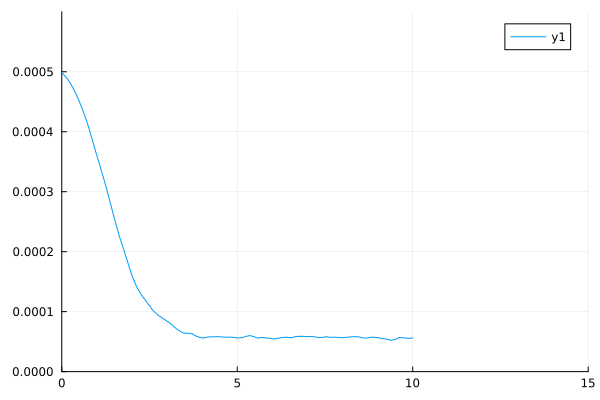

In [80]:
σs = []
for i ∈ 22:404
    σ = σ_geom_ensemble_sol(sols_with_diffusion, i)
    push!(σs, σ)
end
plot(range(0,10,length(σs)), σs, xlim=(0,15), ylim=(0, 600e-6))

In [185]:
n_trajectories1 = 200
n_trajectories2 = 200
n_trajectories_diffusion = 20000
n_times = 100
diffusion_t_end = 20e-6
diffusion_τ_total = 20e-6
;

In [ ]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus1, prob_func!, prob_1plus1_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:17:06
Progress:  60%|█████████████████████████                |  ETA: 0:07:18

In [ ]:
plot(diffusion_over_time)

In [ ]:
σs = σ_vs_time(sols_with_diffusion)[40:end]
plot(range(0, 15, length(σs)), σs, xlim=(0,15), ylim=(0, 600e-6))

In [ ]:
densities = density_vs_time(sols_with_diffusion)[40:end]
plot(range(0,15,length(densities)), densities, yaxis=:log, ylim=(1e6, 3e9))

In [624]:
io = open("sizes_2freq.txt", "w") do io
    for x in σs[44:end]
        println(io, x)
    end
end

In [561]:
io = open("densities_2freq.txt", "w") do io
    for x in densities[44:end]
        println(io, x)
    end
end

In [562]:
io = open("times.txt", "w") do io
    for x in times
        println(io, x)
    end
end

# Figure 2

In [167]:
prob.p.params.s_factor_start = 1.0
prob.p.params.s_factor_end = 1.0
;

In [169]:
n_trajectories1 = 100
n_trajectories2 = 100
n_trajectories_diffusion = 20000
;

In [170]:
@everywhere include("helper_functions.jl")
;

In [171]:
include("compute_size_temperature.jl")
;

## (a)

In [172]:
total_sats = (0.3:0.2:2.1) .* total_sat
@everywhere function update_total_s!(prob, total_sat)
    prob.p.params.total_sat = total_sat
    return nothing
end
; 

In [173]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(prob, prob_func!, prob_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_total_s!, total_sats
)
;

Progress: 100%|█████████████████████████████████████████| Time: 1:21:14
Progress: 100%|█████████████████████████████████████████| Time: 3:12:53m52m
Progress: 100%|█████████████████████████████████████████| Time: 1:20:52
Progress: 100%|█████████████████████████████████████████| Time: 3:11:52
Progress: 100%|█████████████████████████████████████████| Time: 1:22:28


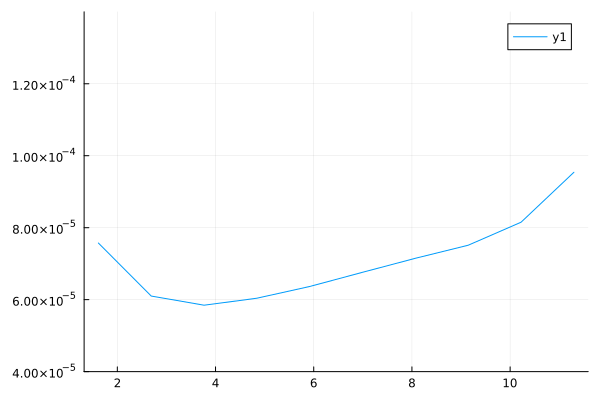

In [175]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
plot(total_sats, (σxs .* σys .* σzs) .^ (1/3), ylim=(40e-6,140e-6))

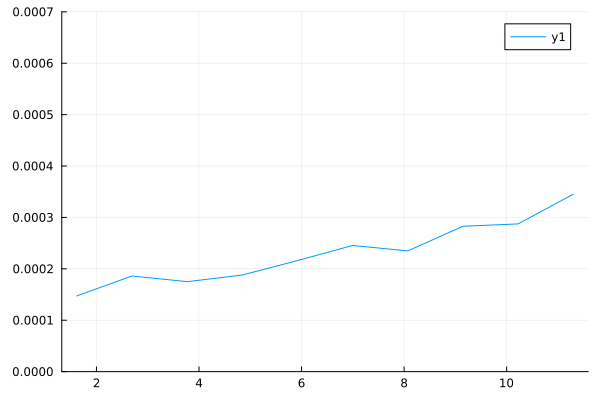

In [177]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
plot(total_sats, (Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

## (b)

In [78]:
detunings = [1.68, 3.16, 4.64, 6.12, 7.60, 9.08, 10.56, 12.04, 13.52, 15.00]
@everywhere function update_detuning!(prob, detuning)
    δ1 = +0.0
    δ2 = -1.00
    δ3 = +0.75
    Δ1 = 1e6 * (detuning + δ1) * (2π / Γ)
    Δ2 = 1e6 * (detuning + δ2) * (2π / Γ)
    Δ3 = 1e6 * (detuning + δ3) * (2π / Γ)
    prob.p.ωs[1] = prob.p.ω0s[end] - prob.p.ω0s[1] + Δ1
    prob.p.ωs[2] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ2
    prob.p.ωs[3] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ3
    return nothing
end
; 

In [79]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(prob, prob_func!, prob_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_detuning!, detunings
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:05:31
Progress: 100%|█████████████████████████████████████████| Time: 0:04:020:00
Progress: 100%|█████████████████████████████████████████| Time: 0:05:37


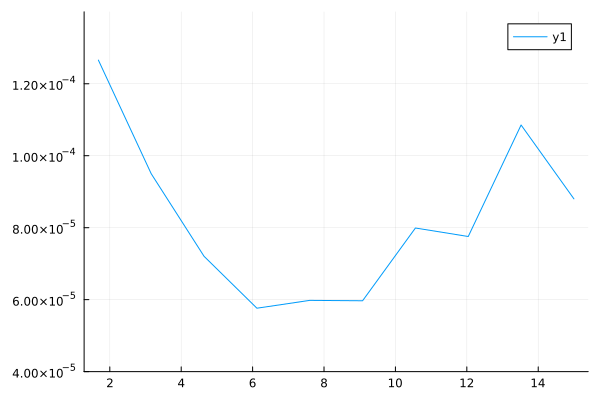

In [82]:
σxs = σx_fit.(all_sols_with_diffusion)
σys = σy_fit.(all_sols_with_diffusion)
σzs = σz_fit.(all_sols_with_diffusion)
plot(detunings, (σxs .* σys .* σzs) .^ (1/3), ylim=(40e-6, 140e-6))

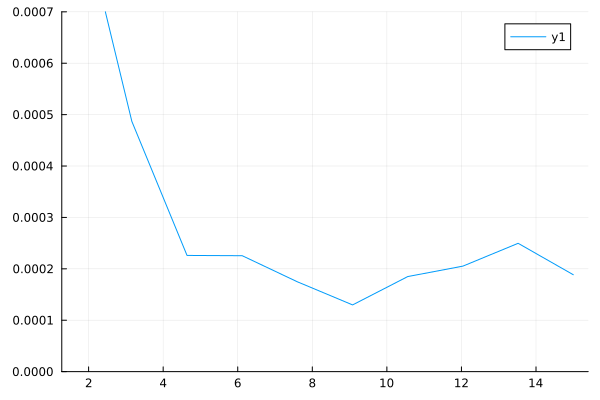

In [81]:
Txs = Tx_fit.(all_sols_with_diffusion)
Tys = Ty_fit.(all_sols_with_diffusion)
Tzs = Tz_fit.(all_sols_with_diffusion)
plot(detunings, (Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

## (c)

In [176]:
δIIas = collect(range(+0.25, -3.25, 15))
@everywhere function update_δIIa!(prob, δIIa)
    detuning = 7.6
    δ2 = δIIa
    Δ2 = 1e6 * (detuning + δ2) * (2π / Γ)
    prob.p.ωs[2] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ2
    return nothing
end
; 

In [177]:
(all_sols_no_diffusion, all_sols_with_diffusion, diffusions, diffusion_errors, diffusions_over_time) = 
    compute_size_temperature_figure2(prob, update_δIIa!, δIIas, n_trajectories1, n_trajectories2, n_trajectories_diffusion)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:17:01
Progress: 100%|█████████████████████████████████████████| Time: 0:10:45:00
Progress: 100%|█████████████████████████████████████████| Time: 0:17:43


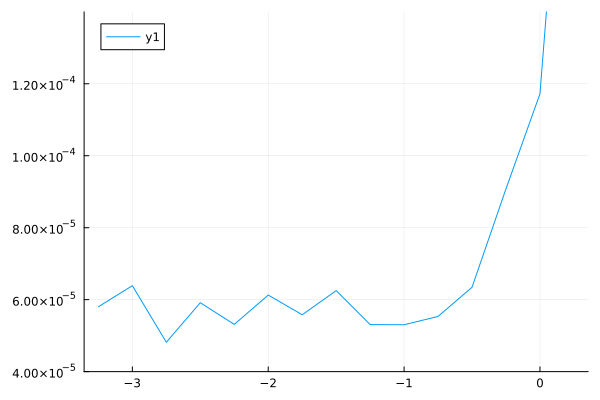

In [179]:
σxs = σx_fit.(all_sols_with_diffusion)
σys = σy_fit.(all_sols_with_diffusion)
σzs = σz_fit.(all_sols_with_diffusion)
plot(δIIas, (σxs .* σys .* σzs) .^ (1/3), ylim=(40e-6, 140e-6))

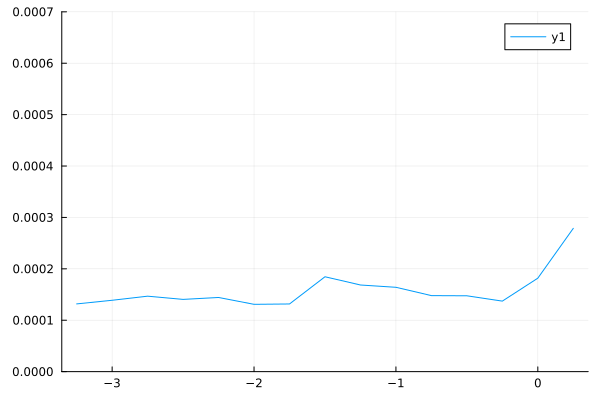

In [180]:
Txs = Tx_fit.(all_sols_with_diffusion)
Tys = Ty_fit.(all_sols_with_diffusion)
Tzs = Tz_fit.(all_sols_with_diffusion)
plot(δIIas, (Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

## (d)

In [87]:
δIIbs = range(-0.75, 2.25, 15)
@everywhere function update_δIIb!(prob, δIIb)
    detuning = 7.6
    δ3 = δIIb
    Δ3 = 1e6 * (detuning + δ3) * (2π / Γ)
    prob.p.ωs[3] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ3
    return nothing
end
; 

In [88]:
(all_sols_no_diffusion, all_sols_with_diffusion, diffusions, diffusion_errors, diffusions_over_time) = 
    compute_size_temperature_figure2(prob, update_δIIb!, δIIbs, n_trajectories1, n_trajectories2, n_trajectories_diffusion)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:08:27
Progress: 100%|█████████████████████████████████████████| Time: 0:06:04:00
Progress: 100%|█████████████████████████████████████████| Time: 0:08:34


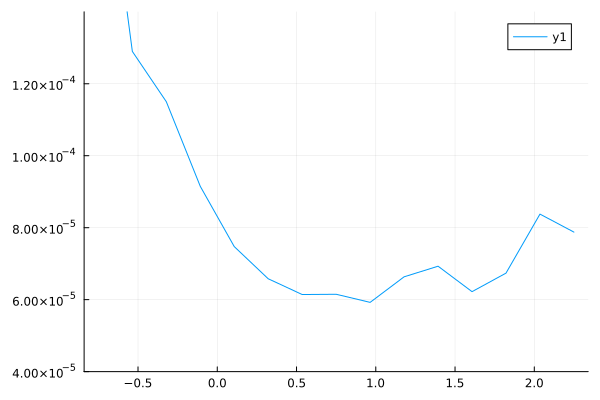

In [93]:
σxs = σx_fit.(all_sols_with_diffusion)
σys = σy_fit.(all_sols_with_diffusion)
σzs = σz_fit.(all_sols_with_diffusion)
plot(δIIbs, (σxs .* σys .* σzs) .^ (1/3), ylim=(40e-6,140e-6))

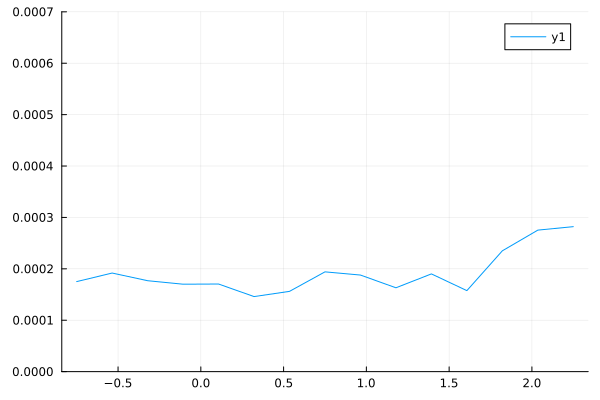

In [94]:
Txs = Tx_fit.(all_sols_with_diffusion)
Tys = Ty_fit.(all_sols_with_diffusion)
Tzs = Tz_fit.(all_sols_with_diffusion)
plot(δIIbs, (Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

## (e)

In [160]:
# Calculate the saturation parameters for IIa and IIb for a range of saturation ratios
II_total_sat = sats[2] + sats[3]
IIba_sats_ratios = range(0.1688, 1.8571, 15)
IIa_sats = (1 ./ (IIba_sats_ratios .+ 1)) .* II_total_sat
IIb_sats = (IIba_sats_ratios ./ (IIba_sats_ratios .+ 1)) .* II_total_sat
IIab_sats = zip(IIa_sats, IIb_sats)
@everywhere function update_IIab_sats!(prob, IIab_sats)
    IIa_sat, IIb_sat = IIab_sats
    prob.p.sats[2] = IIa_sat
    prob.p.sats[3] = IIb_sat
    return nothing
end
; 

In [161]:
(all_sols_no_diffusion, all_sols_with_diffusion, diffusions, diffusion_errors, diffusions_over_time) = 
    compute_size_temperature_figure2(prob, update_IIab_sats!, IIab_sats, n_trajectories1, n_trajectories2, n_trajectories_diffusion)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:17:06
Progress: 100%|█████████████████████████████████████████| Time: 0:10:05
Progress: 100%|█████████████████████████████████████████| Time: 0:16:57


In [165]:
σxs = σx_fit.(all_sols_with_diffusion)
σys = σy_fit.(all_sols_with_diffusion)
σzs = σz_fit.(all_sols_with_diffusion)
plot(IIba_sats_ratios, (σxs .* σys .* σzs) .^ (1/3), ylim=(0,140e-6))

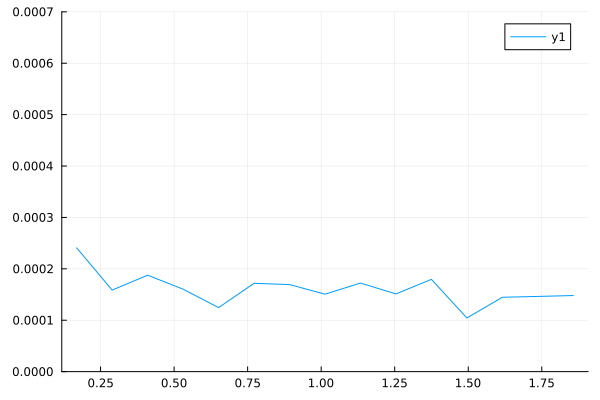

In [167]:
Txs = Tx_fit.(all_sols_with_diffusion)
Tys = Ty_fit.(all_sols_with_diffusion)
Tzs = Tz_fit.(all_sols_with_diffusion)
plot(IIba_sats_ratios, (Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))